In [85]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [86]:
# Given a specified angle (theta) and a list of frequencies (m_values), this function gives
# the x and y coordinates (i.e. the x-axis and y-axis projection) at the given theta for all frequencies
# listed in m_values.

def project_theta(theta, m_values):
    """
    Given a specified angle (theta) and a tensor of frequencies (m_values), this function gives
    the x and y coordinates (i.e. the x-axis and y-axis projection) at the given theta for all frequencies
    listed in m_values. This becomes the coefficients_list.

    Project given 2D vectors onto sin(m*theta) and cos(m*theta) for various m values.

    Parameters:
    theta (torch.tensor): tensor of shape (N,) representing the angle or phase.
    m_values (torch tensor): tensor of m values for projection.

    Returns:
    projections (tensor): Tensor of shape (len(m_values), 2) where the first column is x-coord
    and the second column is y-coord.
    """
    projections = []
    
    for m in m_values:
        sin_m_theta = torch.sin(m * theta)
        cos_m_theta = torch.cos(m * theta)
        
        # Form new vectors using the basis functions
        projected_vectors = torch.stack((cos_m_theta, sin_m_theta), axis=-1)
        
        projections.append(projected_vectors)
    
    return torch.stack(projections, axis=0)



In [87]:
# This function is not used

def evaluate_functions_on_image(image_shape, coefficients_list, m_values, center):
    """
    This function creates the mask.
    First, it creates a grid of (x,y) points with size image_shape. It then computes
    the arctan at each point. Then it calculates the sin and cos (weighted by the values in coefficients_list)
    for each theta value and m value.

    Evaluate the functions defined by coefficients for sin(m*theta) and cos(m*theta)
    on an image of a specific shape, centered at a given coordinate.

    Parameters:
    image_shape (tuple): Shape of the image (height, width).
    coefficients_list (list of tuples): List of coefficients for the sin and cos functions [(a_sin, a_cos), ...].
    m_values (list): List of m values (frequencies) for the basis functions.
    center (tuple): The center coordinate (x_center, y_center).

    Returns:
    torch.Tensor: 2D tensor of the evaluated function (the mask).
    """
    height, width = image_shape
    x_center, y_center = center

    # Create a tuple where y and x are tensors of shape (128,128).
    # The y tensor has rows that span from (-64,64).
    # The x tensor has columns that span from (-64,64).
    # Basically, this just creates a grid of points (for example, the top left value of this grid is (-64,64))...duh
    y, x = torch.meshgrid(torch.arange(height) - y_center, torch.arange(width) - x_center, indexing='ij')
    
    # Compute theta (arctan[y/x]) for each coordinate
    theta = torch.atan2(y.float(), x.float())
    
    # Initialize the evaluated function image
    evaluated_function = torch.zeros(image_shape, dtype=torch.float32)
    
    # Iterates through coefficient_list and m_values simultaneously and computes evaluated_function.
    # Since theta is a tensor of size (image_shape), evaluated_function is also that same size.
    # the += operator adds the value to the preexisting value and reassigns the variable as this new value.
    for (a_cos, a_sin), m in zip(coefficients_list, m_values):
        evaluated_function += a_sin * torch.sin(m * theta) + a_cos * torch.cos(m * theta)
    
    return evaluated_function


In [88]:
def evaluate_functions_on_theta(theta, coefficients_list, m_values):
    """
    For a tensor of theta values, this function computes the sin and cos (weighted by coefficients_list)
    at each point.

    Evaluate the functions defined by coefficients for sin(m*theta) and cos(m*theta)
    on an image of a specific shape, centered at a given coordinate.

    Parameters:
    theta (tensor): tensor of theta values
    coefficients_list (list of tuples): List of coefficients for the sin and cos functions [(a_sin, a_cos), ...].
    m_values (list): List of m values for the basis functions.

    Returns:
    torch.Tensor: 2D tensor of the evaluated function.
    """

    # Initialize the evaluated function image
    evaluated_function = torch.zeros(theta.shape, dtype=torch.float32)
    
    # Sum contributions from each m
    for (a_cos, a_sin), m in zip(coefficients_list, m_values):
        evaluated_function += a_sin * torch.sin(m * theta) + a_cos * torch.cos(m * theta)
    
    return evaluated_function

## LOAD DATA

In [89]:
# Load data with shape (3, 128, 128) for q_x, q_y, and intensity

# data = np.load('image1.npz')['data']
# data = np.load('images/image_111001.npz')['data']
data = np.load('images/image_111019.npz')['data']

# Split into theta and intensity

# computes arctan(q_y/q_x) to get tensor values which are dependent on angle
data_theta = torch.atan2(torch.tensor(data[1]), torch.tensor(data[0]))
data_intensity = torch.tensor(data[2])
print(data.shape)
# plt.imshow(data_theta)
# plt.colorbar()

(3, 128, 128)


In [90]:
data = np.load("cooldown 54.5K -29mT/image_121521.npz")['data']
data_theta = torch.atan2(torch.tensor(data[1]), torch.tensor(data[0]))
data_intensity = torch.tensor(data[2])

torch.Size([128, 128])


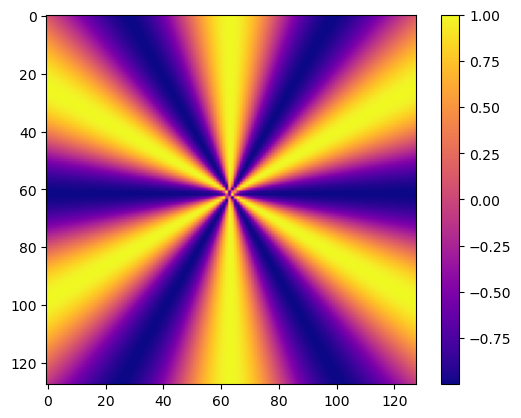

In [91]:
# Example of how evaluate_functions_on_theta() works
evaluate_image_theta = evaluate_functions_on_theta(data_theta, np.array([[1, 0]]), [6])
plt.imshow(evaluate_image_theta.detach(), cmap='plasma')
plt.colorbar()
print(evaluate_image_theta.shape)

tensor([0.0000, 1.0472, 2.0944, 3.1416, 4.1888, 5.2360])
tensor([[ 6.0000e+00,  0.0000e+00],
        [ 4.7684e-07,  9.1391e-08],
        [ 4.1723e-07, -3.6160e-07],
        [-5.9605e-08, -2.6227e-07],
        [-1.1921e-06, -8.4240e-07],
        [-2.0862e-06,  7.5498e-07],
        [ 6.0000e+00,  2.6227e-06],
        [ 2.3842e-06, -1.2080e-06],
        [ 2.0266e-06, -1.6252e-06],
        [ 0.0000e+00, -3.8862e-06],
        [-4.7684e-06, -4.9668e-07],
        [-5.4836e-06, -1.0809e-06]])
torch.Size([128, 128])


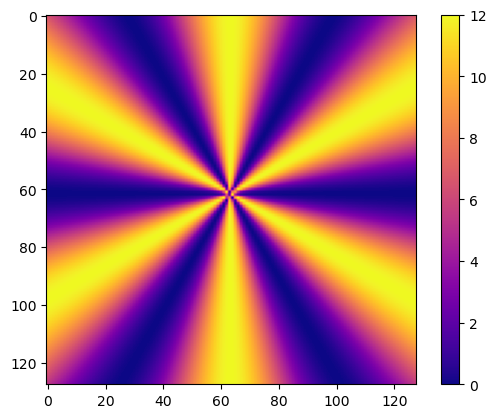

In [92]:
# Set of m_values -- reduce for broader angles
m_vals = torch.arange(12)

# six-fold signal
angles = torch.arange(0, 6) * 2 * torch.pi / 6.
print(angles)
# Projection onto circular harmonics (cos(m\theta), sin(m\theta))
projection = project_theta(angles, m_vals).sum(1)

print(projection)

evaluate_image_theta = evaluate_functions_on_theta(data_theta, projection, m_vals)
print(evaluate_image_theta.shape)
plt.imshow(evaluate_image_theta.detach(), cmap='plasma')
plt.colorbar()

## OPTIMIZE OFFSET ANGLE

In [93]:
# Performs gradient descent to optimize the offset angle

max_iter = 401

# initialize offset angle at zero
offset = torch.tensor(0.)
# tells torch which variable to perform graient descent on
offset.requires_grad = True
# uses the Adam optimizer
opt = torch.optim.Adam([offset], lr=1e-2)

for i in range(max_iter):
    # project_theta() will find the weighting coefficients for sin and cos functions in the mask
    projection = project_theta(angles + offset, m_vals).sum(1)
    # evaluate_functions_on_theta() will create the mask with the respective weighting coeffs from projection
    evaluate_image_theta = evaluate_functions_on_theta(data_theta, projection, m_vals)
    # multiply element-wise the data_intensity and the mask, sum all the values in the tensor
    loss = -(data_intensity * evaluate_image_theta).sum()
    # performs the gradient descent as it tries to minimize loss by changing the offset angle
    opt.zero_grad()
    loss.backward()
    opt.step()
    if i % 100 == 0:
        print(f"loss: {loss.item()}, offset angle: {offset.item() * 180/torch.pi}°")


loss: -265402.0294003974, offset angle: 0.5729577823242186°
loss: -304116.87025028747, offset angle: 16.4160745097278°
loss: -304117.31393005897, offset angle: 16.361643024684675°
loss: -304117.3107292479, offset angle: 16.361178571821114°
loss: -304117.27382766805, offset angle: 16.361185402010285°


offset angle: 16.361185402010285°


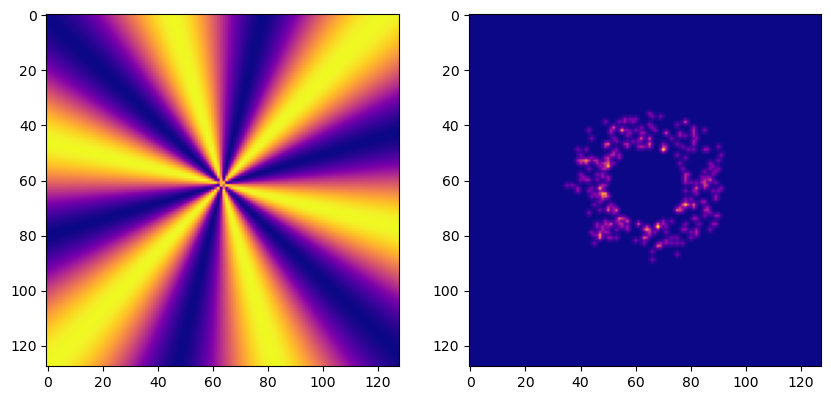

In [94]:
# Plotting the image rotated by the offset angle alongside the original intensity
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
print(f"offset angle: {offset.item() * 180/torch.pi}°")
ax[0].imshow(evaluate_image_theta.detach(), cmap='plasma')
ax[1].imshow(data_intensity.detach(), cmap='plasma')

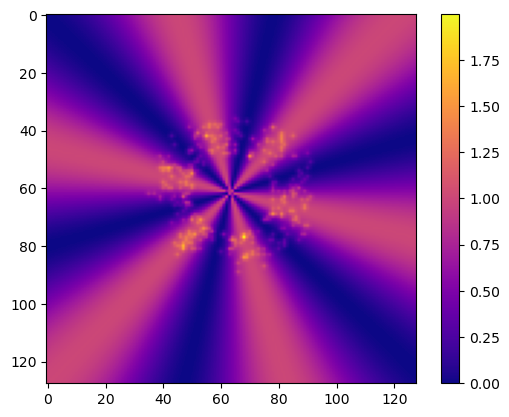

In [95]:
plt.imshow((evaluate_image_theta / evaluate_image_theta.abs().max() + data_intensity / data_intensity.abs().max()).detach(), cmap='plasma')
plt.colorbar()